# Détection de la Pneumonie par Imagerie Thoracique

Ce notebook présente une étude comparative de plusieurs architectures de Deep Learning pour la classification d'images de radiographies thoraciques (Normal vs Pneumonie).

Les modèles implémentés sont :
1. **CNN Personnalisé** (avec Dropout)
2. **MobileNet** (Transfer Learning)
3. **ResNet50** (Transfer Learning)
4. **VGG16** (Transfer Learning)
5. **Hybride ResNet-ViT** (Modélisation des dépendances à longue portée)

## 1. Configuration et Chargement des Données

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Layer, MultiHeadAttention, LayerNormalization, Add, Reshape
from tensorflow.keras.applications import MobileNet, ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
import kagglehub

# Téléchargement du dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Chemin des données :", path)

# Définition des répertoires
train_dir = os.path.join(path, 'chest_xray/train')
val_dir = os.path.join(path, 'chest_xray/val')
test_dir = os.path.join(path, 'chest_xray/test')

# Paramètres
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Chemin des données : /kaggle/input/chest-xray-pneumonia


## 2. Prétraitement et Augmentation des Données

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# --- Parameters ---
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.25

# --- Data augmentation for training ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=15,
    brightness_range=[0.8, 1.2],
    validation_split=VAL_SPLIT
)

# --- No augmentation for validation ---
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT
)

# --- Training generators for each class ---
normal_train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['NORMAL'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

pneu_train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['PNEUMONIA'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,
    class_mode='binary',
    shuffle=True,
    subset='training'
)

# --- Validation generators for each class ---
normal_val_generator = val_datagen.flow_from_directory(
    train_dir,
    classes=['NORMAL'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

pneu_val_generator = val_datagen.flow_from_directory(
    train_dir,
    classes=['PNEUMONIA'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE // 2,
    class_mode='binary',
    shuffle=False,
    subset='validation'
)

# --- FIXED: Balanced generator with correct labels ---
def balanced_generator(normal_gen, pneu_gen):
    while True:
        normal_imgs, _ = next(normal_gen)  # Ignore the labels (they're wrong)
        pneu_imgs, _ = next(pneu_gen)      # Ignore the labels (they're wrong)

        # Create correct labels manually
        normal_labels = np.zeros(len(normal_imgs))  # NORMAL = 0
        pneu_labels = np.ones(len(pneu_imgs))       # PNEUMONIA = 1

        X = np.concatenate([normal_imgs, pneu_imgs], axis=0)
        y = np.concatenate([normal_labels, pneu_labels], axis=0)

        # Shuffle
        idx = np.arange(len(y))
        np.random.shuffle(idx)
        yield X[idx], y[idx]

# --- Create balanced generators ---
train_generator_balanced = balanced_generator(normal_train_generator, pneu_train_generator)
val_generator_balanced = balanced_generator(normal_val_generator, pneu_val_generator)

# --- Calculate steps ---
steps_per_epoch = max(len(normal_train_generator), len(pneu_train_generator))
validation_steps = max(len(normal_val_generator), len(pneu_val_generator))

print(f"Training steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")

# --- VERIFY the fix ---
print("\n=== VERIFICATION ===")
for i in range(3):
    X, y = next(train_generator_balanced)
    print(f"Batch {i+1}: Unique labels: {np.unique(y, return_counts=True)}")

Found 1006 images belonging to 1 classes.
Found 2907 images belonging to 1 classes.
Found 335 images belonging to 1 classes.
Found 968 images belonging to 1 classes.
Training steps per epoch: 182
Validation steps: 61

=== VERIFICATION ===
Batch 1: Unique labels: (array([0., 1.]), array([16, 16]))
Batch 2: Unique labels: (array([0., 1.]), array([16, 16]))
Batch 3: Unique labels: (array([0., 1.]), array([16, 16]))


In [ ]:
# Debug: Check what labels are being generated
print("Checking training generator labels...")
for i in range(3):
    X, y = next(train_generator_balanced)
    print(f"Batch {i+1}: Labels = {y[:10]}, Unique labels: {np.unique(y, return_counts=True)}")

print("\nChecking validation generator labels...")
for i in range(3):
    X, y = next(val_generator_balanced)
    print(f"Batch {i+1}: Labels = {y[:10]}, Unique labels: {np.unique(y, return_counts=True)}")

# Also check the original generators
print("\nNormal generator class mode:", normal_train_generator.class_indices)
print("Pneumonia generator class mode:", pneu_train_generator.class_indices)

Checking training generator labels...
Batch 1: Labels = [1. 1. 0. 1. 0. 1. 0. 0. 0. 1.], Unique labels: (array([0., 1.]), array([16, 16]))
Batch 2: Labels = [1. 0. 0. 1. 1. 0. 1. 0. 1. 0.], Unique labels: (array([0., 1.]), array([16, 16]))
Batch 3: Labels = [1. 0. 1. 1. 0. 1. 0. 1. 0. 0.], Unique labels: (array([0., 1.]), array([16, 16]))

Checking validation generator labels...
Batch 1: Labels = [1. 1. 0. 0. 1. 1. 1. 0. 0. 1.], Unique labels: (array([0., 1.]), array([16, 16]))
Batch 2: Labels = [1. 1. 1. 1. 0. 0. 1. 0. 0. 0.], Unique labels: (array([0., 1.]), array([16, 16]))
Batch 3: Labels = [1. 0. 1. 1. 1. 0. 1. 0. 1. 1.], Unique labels: (array([0., 1.]), array([16, 16]))

Normal generator class mode: {'NORMAL': 0}
Pneumonia generator class mode: {'PNEUMONIA': 0}


## 3. Modèle 1 : CNN Personnalisé avec Dropout

In [ ]:
def build_custom_cnn():
    model = Sequential([
        # 1st conv block
        Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.25),  # Increased from 0.2

        # 2nd conv block
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.35),  # Increased from 0.3

        # 3rd conv block
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.45),  # Increased from 0.4

        # 4th conv block
        Conv2D(256, (3,3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.5),

        # Dense layers
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Increased L2
        BatchNormalization(),
        Dropout(0.6),  # Increased from 0.5
        Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

cnn_model = build_custom_cnn()
cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,464,353 (51.36 MB)

 Trainable params: 13,462,433 (51.36 MB)

 Non-trainable params: 1,920 (7.50 KB)

## 4. Modèle 2 : MobileNet (Transfer Learning)

In [ ]:
def build_mobilenet():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

mobilenet_model = build_mobilenet()


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
mobilenet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,360,193 (12.82 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

## 5. Modèle 3 : ResNet50 (Transfer Learning)

In [ ]:
def build_resnet50():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

resnet_model = build_resnet50()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
resnet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 6. Modèle 4 : VGG16 (Transfer Learning)

In [ ]:
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg_model = build_vgg16()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## 7. Modèle 5 : Hybride ResNet-ViT

Ce modèle combine la capacité d'extraction de caractéristiques locales de ResNet avec la capacité de modélisation des dépendances à longue portée des Vision Transformers (ViT).

In [ ]:
def transformer_block(x, embed_dim, num_heads, ff_dim, dropout=0.1):
    # Attention multi-têtes
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(Add()([x, attn_output]))

    # Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(Add()([out1, ffn_output]))

def build_resnet_vit_hybrid():
    # Utilisation de ResNet50 comme extracteur de caractéristiques (backbone)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Sortie de ResNet50 : (7, 7, 2048)
    x = base_model.output

    # Aplatir les dimensions spatiales pour le Transformer : (49, 2048)
    # 7*7 = 49 patches
    x = Reshape((49, 2048))(x)

    # Bloc Transformer pour capturer les dépendances à longue portée
    x = transformer_block(x, embed_dim=2048, num_heads=4, ff_dim=1024)

    # Global Average Pooling sur les patches
    x = GlobalAveragePooling2D()(Reshape((7, 7, 2048))(x))

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

hybrid_model = build_resnet_vit_hybrid()


In [ ]:
hybrid_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 95,191,169 (363.13 MB)

 Trainable params: 71,603,457 (273.15 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 8. Entraînement des Modèles


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 15  # Increase epochs, early stopping will stop it when needed

# Callbacks to prevent overfitting
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

histories = {}

models = {
    "CNN Custom": cnn_model,
    "MobileNet": mobilenet_model,
    "ResNet50": resnet_model,
    "VGG16": vgg_model,
    "ResNet-ViT Hybrid": hybrid_model
}

for name, model in models.items():
    print(f"Training {name}...")

    history = model.fit(
        train_generator_balanced,
        steps_per_epoch=steps_per_epoch,
        epochs=EPOCHS,
        validation_data=val_generator_balanced,
        validation_steps=validation_steps,
        callbacks=callbacks,  # Add callbacks here
        verbose=1
    )

    histories[name] = history
    print(f"\n{name} training complete!\n")

Training CNN Custom...
Epoch 1/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6973 - loss: 7.5023 - precision: 0.7732 - recall: 0.5492 - val_accuracy: 0.4987 - val_loss: 16.6197 - val_precision: 0.4987 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 2/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 165s 911ms/step - accuracy: 0.8807 - loss: 6.2536 - precision: 0.9100 - recall: 0.8457 - val_accuracy: 0.4987 - val_loss: 16.1468 - val_precision: 0.4987 - val_recall: 1.0000 - learning_rate: 1.0000e-04
Epoch 3/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9007 - loss: 5.4388 - precision: 0.9148 - recall: 0.8842 - val_accuracy: 0.6571 - val_loss: 5.3038 - val_precision: 0.5926 - val_recall: 0.9979 - learning_rate: 1.0000e-04
Epoch 4/15
182/182 ━━━━━━━━━━━━━━━━━━━━ 155s 856ms/step - accuracy: 0.9143 - loss: 4.7042 - precision: 0.9380 - recall: 0.8876 - val_accuracy: 0.9109 - val_loss: 4.2135 - val_precision: 0.8909 - val_recall: 0.9360 - learning_rate: 1.0000e-04
Epoch 5/15
18

## 9. Évaluation et Comparaison

61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 381ms/step - accuracy: 0.8944 - loss: 1.0567 - precision: 0.9967 - recall: 0.7906
61/61 ━━━━━━━━━━━━━━━━━━━━ 23s 378ms/step - accuracy: 0.9729 - loss: 0.0720
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 407ms/step - accuracy: 0.8250 - loss: 0.4207
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 418ms/step - accuracy: 0.9292 - loss: 0.1871
61/61 ━━━━━━━━━━━━━━━━━━━━ 25s 410ms/step - accuracy: 0.4980 - loss: 0.6931
              Modèle  Précision (Test)  Perte (Test)
0         CNN Custom          0.891293      1.078812
1          MobileNet          0.968058      0.079189
2           ResNet50          0.829469      0.415372
3              VGG16          0.933539      0.181448
4  ResNet-ViT Hybrid          0.498712      0.693147


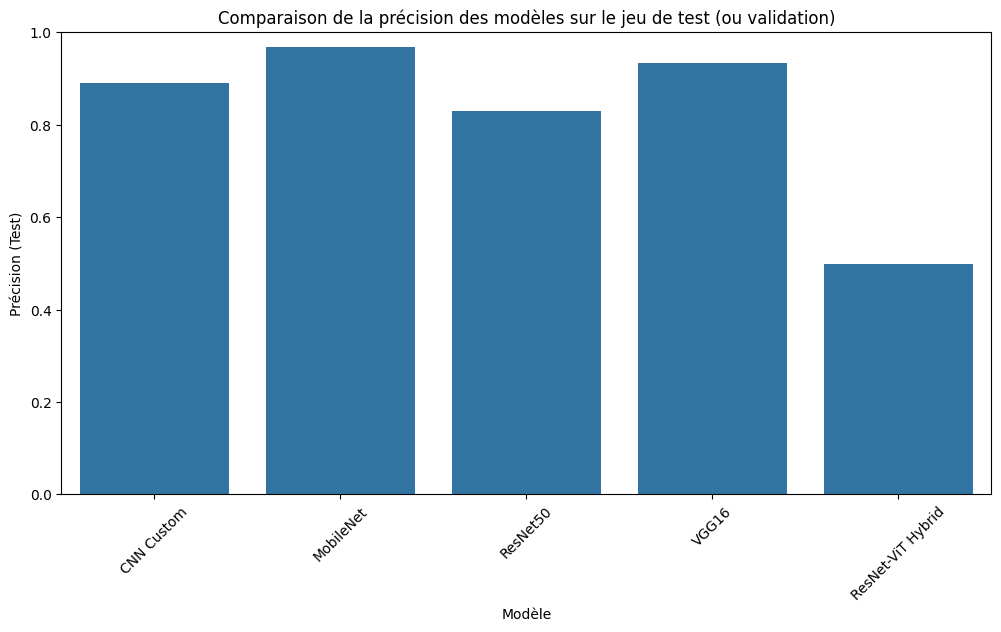

In [ ]:
results = []

for name, model in models.items():
    eval_result = model.evaluate(val_generator_balanced, steps=validation_steps)

    # eval_result[0] is always loss
    # eval_result[1] is usually the first metric (accuracy)
    loss = eval_result[0]
    acc = eval_result[1] if len(eval_result) > 1 else None

    results.append({"Modèle": name, "Précision (Test)": acc, "Perte (Test)": loss})

df_results = pd.DataFrame(results)
print(df_results)

# Visualisation
plt.figure(figsize=(12, 6))
sns.barplot(x='Modèle', y='Précision (Test)', data=df_results)
plt.title('Comparaison de la précision des modèles sur le jeu de test (ou validation)')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()
